# ML Toolbox 2
## Binary Classification Using K-Nearest Neighbors
Ryan Haggerty

## Part 1. Data Processing

### Step 1.
Get the dataset (‘winequality-white.csv’) from the following URL:
https://archive.ics.uci.edu/ml/datasets/wine+quality
The dataset consists of characteristics of white wine (e.g., alcohol content,
density, amount of citric acid, pH, etc) with target variable “quality” representing
rating of wine.
Eleven Input variables (based on physicochemical tests):
- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol

Output variable (based on sensory data):
- quality (score between 0 and 10)

In [29]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, classification_report

In [ ]:
# 'winequality-white.csv' is downloaded into parent folder

### Step 2.
Read in the ‘winequality-white.csv’ file as a Pandas data frame.

In [16]:
wine=pd.read_csv('/Users/ryguy/Documents/UNL/Classes/Practical Machine Learning/winequality-white.csv', header=0)
# See the key values
print("\nKey Values: \n", list(wine.keys()))
wine.head(5)


Key Values: 
 ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### Step 3.
The target will be the ‘quality’ column which represents rating of wine and
ranges from 3 to 8. You will need to convert it into a two-category variable
consisting of “good” (quality > 5) & “bad” (quality <= 5). Your target vector
should have 0s (representing “bad” quality wine) and 1s (representing “good”
quality wine).

In [25]:
# create input array
X = wine.drop('quality',axis=1)

# create output vector where quality >5 and quality <=5 is recoded to 1 and 0, respectively
y =(wine["quality"] >= 6).astype(np.int32)

### Step 4. (Optional)
You may apply the data pre-processing steps of Exploratory Data
Analysis (EDA) that you learned previously.

In [27]:
# check for any NaN values in dataset
wine.isna().values.any()

False

### Step 5.
You need to identify and report the redundant features

In [28]:
wine.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [33]:
# find redundant features through Pearson correlation
wine.corr()['quality'].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.435575
pH                      0.099427
sulphates               0.053678
free sulfur dioxide     0.008158
citric acid            -0.009209
residual sugar         -0.097577
fixed acidity          -0.113663
total sulfur dioxide   -0.174737
volatile acidity       -0.194723
chlorides              -0.209934
density                -0.307123
Name: quality, dtype: float64

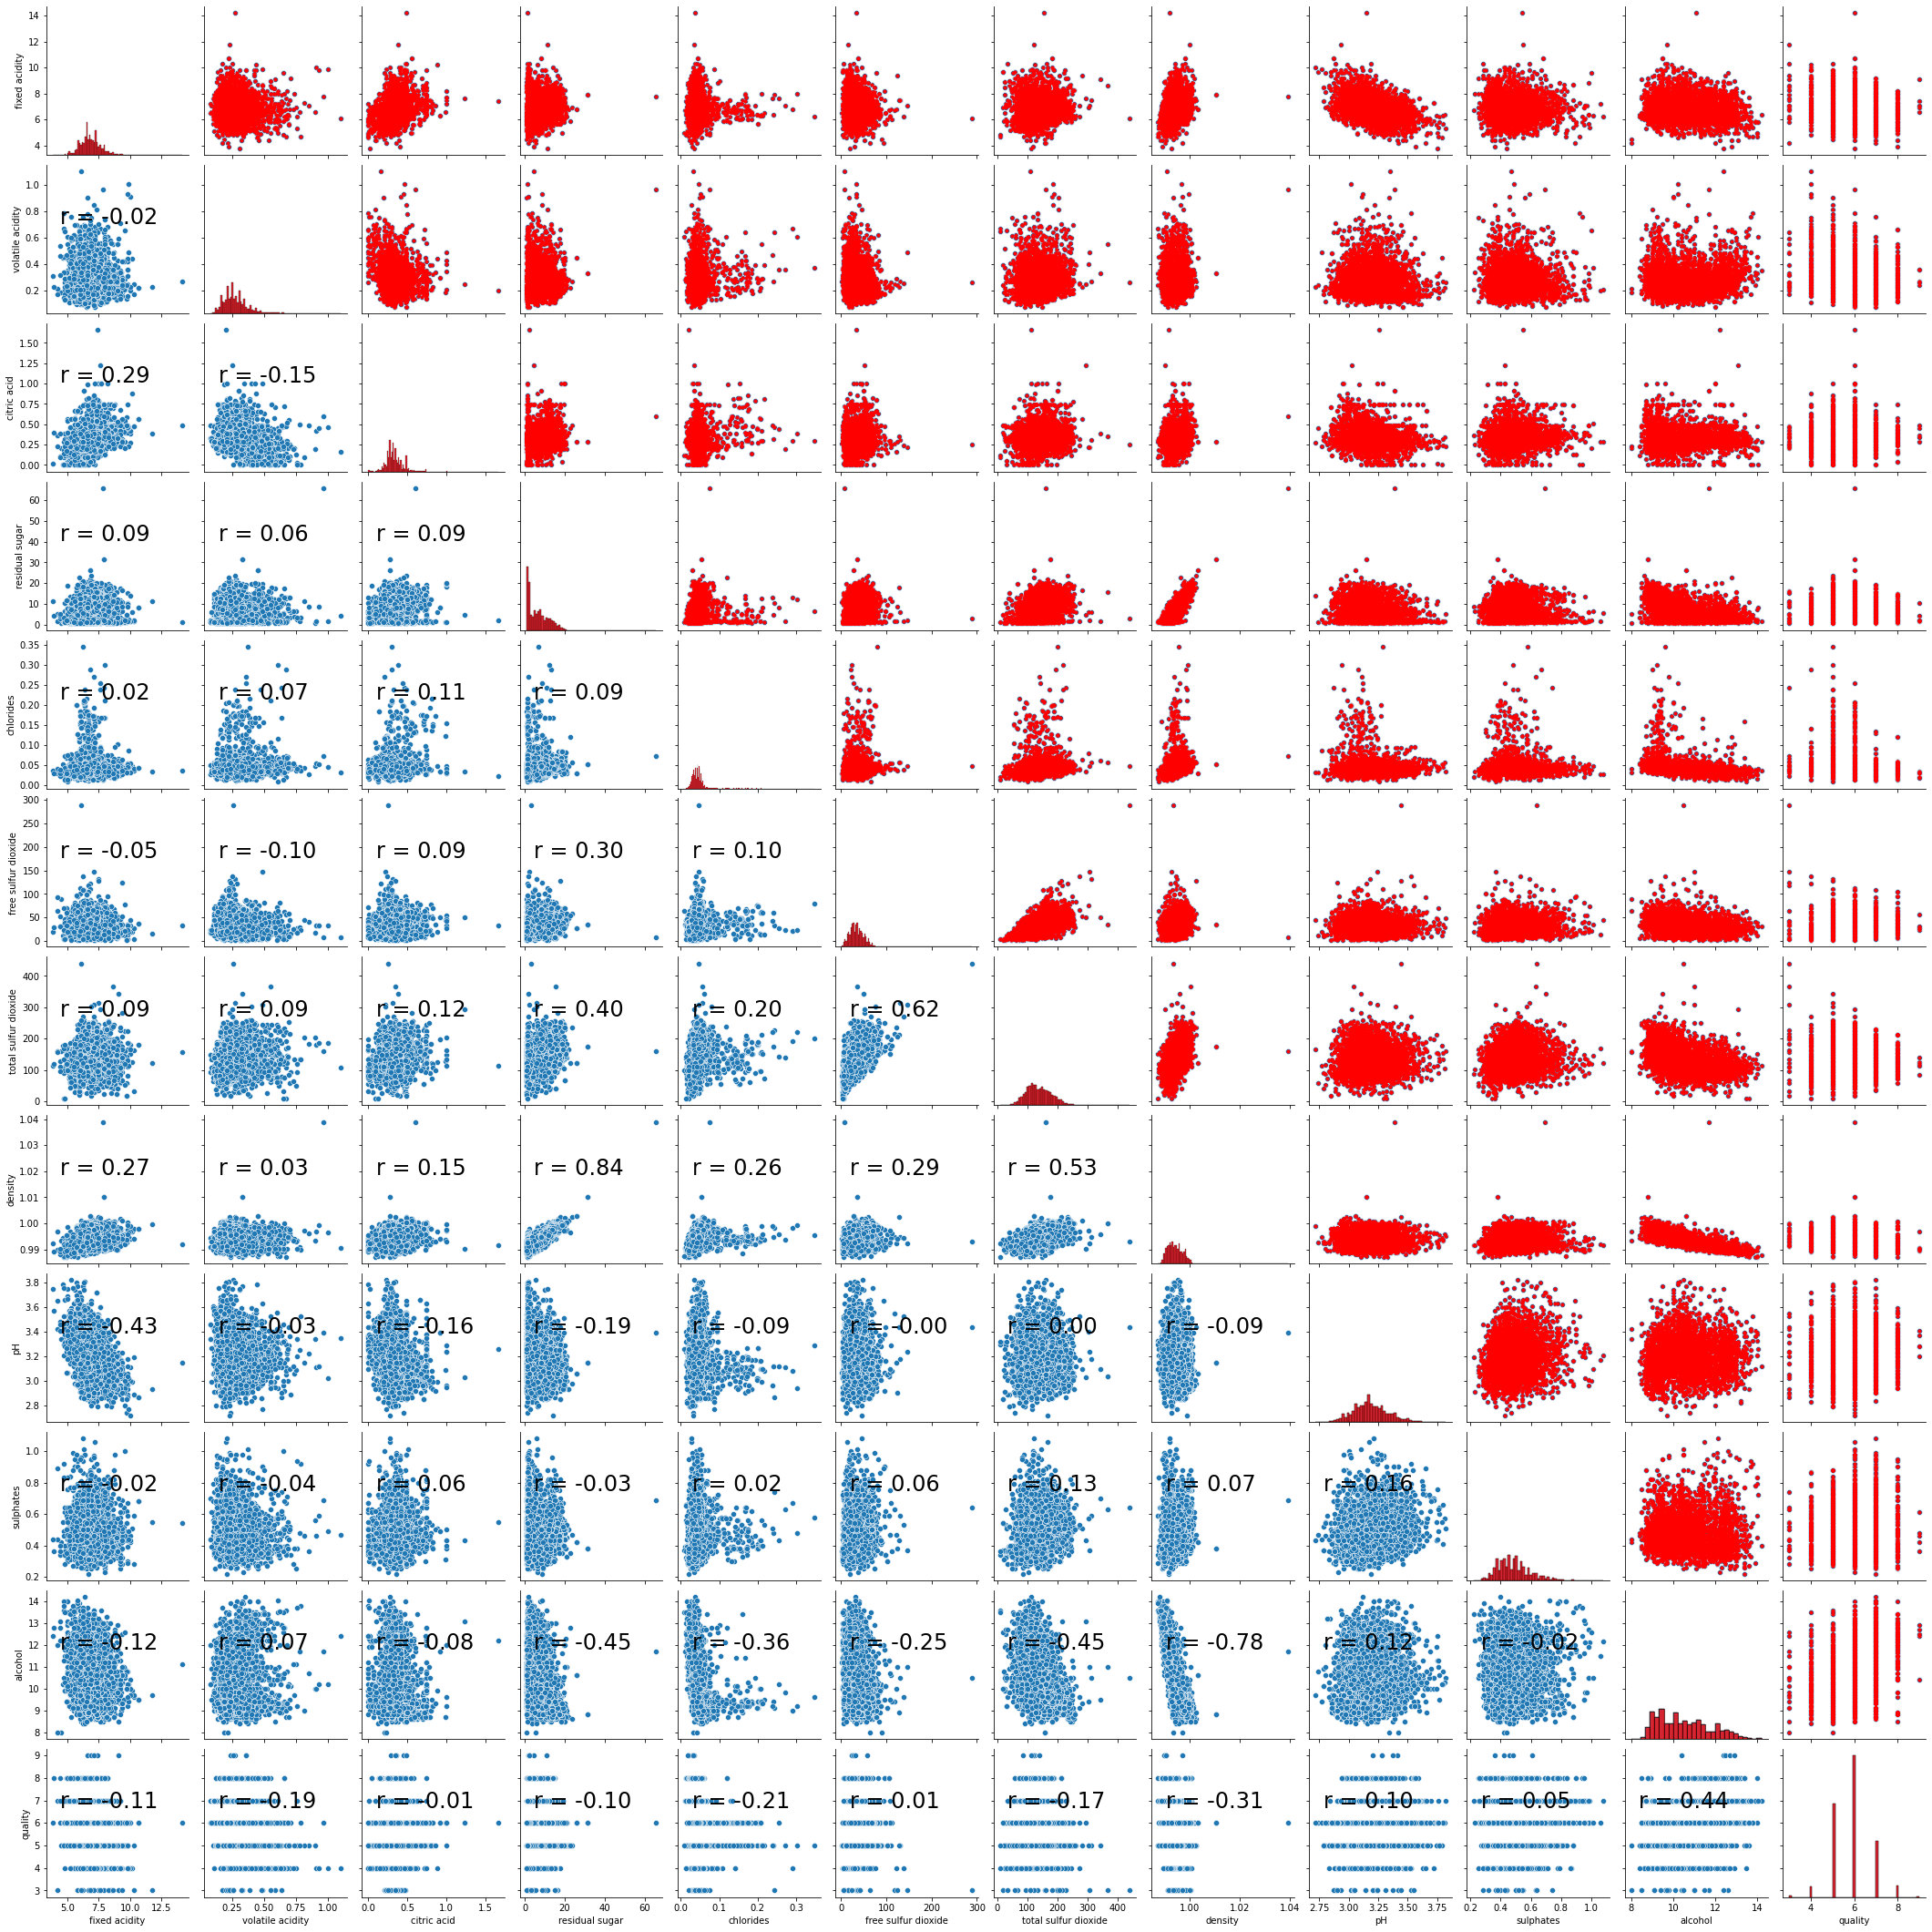

In [35]:
# find redundant features through Pearson correlation
# Matplotlib and seaborn for plotting
# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair plot
g = sns.pairplot(wine)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
#g.map_diag(sns.distplot, kde=False, color = 'red') # distplot is deprecated
#g.map_diag(sns.displot, kde=False, color = 'red')
g.map_diag(sns.histplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
#g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

In [ ]:
# based on results, density seems like a redundant feature with residual sugar and alcohol
# residual sugar has a lower correlation with quality, so residual sugar is dropped

### Step 6a.
Drop the redundant features and implement the steps up to 13 (you need to
perform grid search in step 9 just once). See whether dropping features improves
the performance measures (e.g., F1 score). If not then keep the features. You
need to understand that having highly correlated features will not contribute
towards meaningful distance calculation. Moreover, it will increase the timecomplexity. You will have to determine this experimentally.

In [36]:
# first keep all reatures

In [ ]:
# then drop redundant features (residual sugar)

### Step 7.
Partition the dataset into train and test set (80%-20%). It should return two
feature matrices X_train, X_test; and two target vectors y_train & y_test.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Step 8.
Standardize each feature of your training & test set. You may use one of the
following techniques.

**Technique 1:**

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)

X = scaler.transform(X)
 
**Technique 2:**

from sklearn.preprocessing import scale

X = scale(X)

In [38]:
from sklearn.preprocessing import scale
X_train=scale(X_train)
X_test=scale(X_test)

## Part 2. Model Evaluation

### Step 9.
**Model Selection:** Using Scikit-Learn’s GridSearchCV select the best model.
For the “param_grid” use the following attributes.
 - 'n_neighbors': [1, 3, 5, 7, 9, 15, 21, 23, 33, 35, 37]
 - 'p': [1, 2, 10, 100]
 - 'weights': ["uniform", "distance"]}

The “scoring” attribute should be ‘f1’.

Use 10-fold cross-validation: cv = 10

In [42]:
%%time
# apply GridSearchCV using parameters ranges specified above

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'n_neighbors': [1,3,5,7,9,15,21,23,33,35,37], 'p': [1, 2, 10, 100], 
              'weights': ["uniform", "distance"]}

knn_clf = KNeighborsClassifier()

knn_cv = GridSearchCV(knn_clf, param_grid, scoring='f1', cv=10, verbose=3, n_jobs=-1)
knn_cv.fit(X_train, y_train)


params_optimal_knn = knn_cv.best_params_

print("Best Score: %f" % knn_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn)
print("\n")

Fitting 10 folds for each of 88 candidates, totalling 880 fits
Best Score: 0.882573
Optimal Hyperparameter Values:  {'n_neighbors': 35, 'p': 1, 'weights': 'distance'}


Wall time: 35.3 s


In [ ]:
# without dropping redundant values, the optimal parameters are
# K = 35, p = 1, weights = 'distance'
# best score = 0.882573
# wall time = 34.3s

### Step 10.
Train Scikit-Learn’s KNeighborsClassifier model using the optimal
hyperparameter values obtained from GridSearchCV.

In [45]:
# The Minkowski distance based model (i.e., knn_cv) is already trained with the optimal hyperparameter values.
# We can use the optimal model (knn_cv) for prediction.
# Or we can use the optimal hyperparameter values to train a new model, as follows.
knnbest = KNeighborsClassifier(**params_optimal_knn)

knnbest.fit(X_train, y_train)

y_train_predicted = knnbest.predict(X_train)

train_accuracy_knn = np.mean(y_train_predicted == y_train)
print("\nTraining Accuracy: ", train_accuracy_knn)


Training Accuracy:  1.0


### Step 11.
Evaluate your model on the train data using the cross_val_score function and
report the average accuracy.

In [69]:
scores = cross_val_score(knnbest, X_train, y_train, scoring='accuracy', cv=5)
print(scores)

print("Accuracy Score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.85076531 0.83418367 0.8252551  0.82886335 0.82120051]
Accuracy Score: 0.832 (+/- 0.02)


### Step 12.
Report the train data performance measures: precision, recall, F1 score and
confusion matrix.

In [49]:
y_train_pred = cross_val_predict(knnbest, X_train, y_train, cv=5)

confusion_matrix(y_train, y_train_pred)

array([[ 816,  469],
       [ 189, 2444]], dtype=int64)

In [50]:
precision = precision_score(y_train, y_train_pred) 
print("Training: Precision = %f" % precision)

recall = recall_score(y_train, y_train_pred)
print("Training: Recall = %f" % recall)


f1 = f1_score(y_train, y_train_pred)
print("Training: F1 Score = %f" % f1)

Training: Precision = 0.838998
Training: Recall = 0.928219
Training: F1 Score = 0.881356


### Step 13.
Generate the ROC curve for the train data.

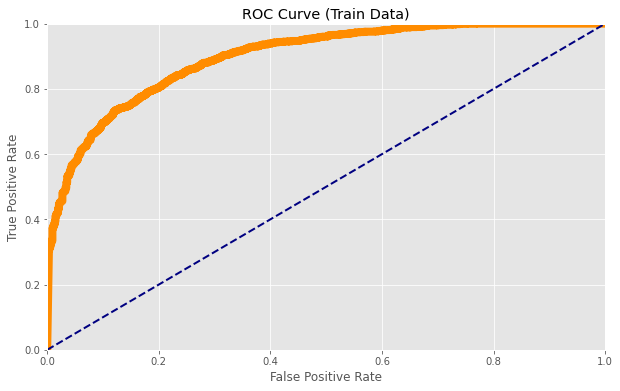

In [53]:

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, color='darkorange', linewidth=8, label=label) 
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.axis([0, 1, 0, 1])
    plt.title(label)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr, "ROC Curve (Train Data)")
plt.show()

### Step 6b.
Redo steps 9-13 but with the dropped redundant features and compare the results

In [62]:
X1=X.drop('residual sugar',axis=1)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, test_size=0.2, random_state=0)
from sklearn.preprocessing import scale
X_train1=scale(X_train1)
X_test1=scale(X_test1)

In [65]:
%%time
# apply GridSearchCV using parameters ranges specified above

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'n_neighbors': [1,3,5,7,9,15,21,23,33,35,37], 'p': [1, 2, 10, 100], 
              'weights': ["uniform", "distance"]}

knn_clf1 = KNeighborsClassifier()

knn_cv1 = GridSearchCV(knn_clf1, param_grid, scoring='f1', cv=10, verbose=3, n_jobs=-1)
knn_cv1.fit(X_train1, y_train1)


params_optimal_knn1 = knn_cv1.best_params_

print("Best Score: %f" % knn_cv1.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn1)
print("\n")

Fitting 10 folds for each of 88 candidates, totalling 880 fits
Best Score: 0.882681
Optimal Hyperparameter Values:  {'n_neighbors': 21, 'p': 1, 'weights': 'distance'}


Wall time: 32.8 s


In [70]:
knnbest1 = KNeighborsClassifier(**params_optimal_knn1)

knnbest1.fit(X_train1, y_train1)

y_train_predicted = knnbest1.predict(X_train1)

train_accuracy_knn1 = np.mean(y_train_predicted == y_train1)
print("\nTraining Accuracy: ", train_accuracy_knn1)
scores = cross_val_score(knnbest1, X_train1, y_train1, scoring='accuracy', cv=5)
print(scores)

print("Accuracy Score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Training Accuracy:  1.0
[0.83290816 0.83545918 0.81122449 0.81864623 0.83141762]
Accuracy Score: 0.826 (+/- 0.02)


In [72]:
y_train_pred1 = cross_val_predict(knnbest1, X_train1, y_train1, cv=5)

confusion_matrix(y_train1, y_train_pred1)

array([[ 808,  477],
       [ 205, 2428]], dtype=int64)

In [73]:
precision1 = precision_score(y_train1, y_train_pred1) 
print("Training: Precision = %f" % precision1)

recall1 = recall_score(y_train1, y_train_pred1)
print("Training: Recall = %f" % recall1)


f1_1 = f1_score(y_train1, y_train_pred1)
print("Training: F1 Score = %f" % f1_1)

Training: Precision = 0.835800
Training: Recall = 0.922142
Training: F1 Score = 0.876851


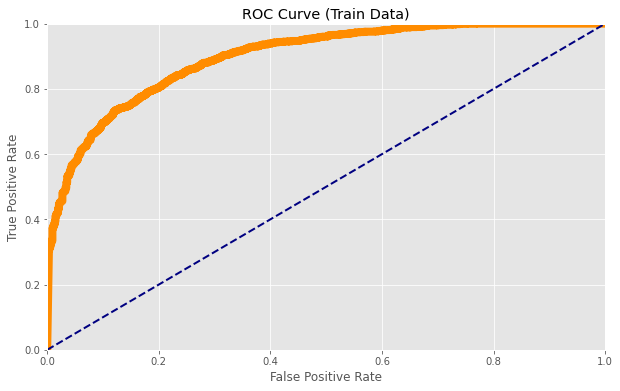

In [75]:
fpr, tpr, thresholds = roc_curve(y_train1, y_scores)

plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, color='darkorange', linewidth=8, label=label) 
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.axis([0, 1, 0, 1])
    plt.title(label)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr, "ROC Curve (Train Data)")
plt.show()

### Step 14.
Report the area under the curve (AUC) score for the ROC curve.

In [76]:
# we will use model with dropped redundant data since it reaches the same accuracy but takes less time
# Area under ROC curve
roc_auc_score(y_train1,y_scores)

0.8971604049766433

### Step 15.
Generate the precision-recall curve for train data. Report the optimal threshold.

Precisions:  [0.72734807 0.72727273 0.72747374 ... 0.98306878 0.98305085 1.        ]

Recalls:  [1.         0.99962021 0.99962021 ... 0.35282947 0.35244968 0.        ]

Thresholds:  [0.04091749 0.05775475 0.05985479 ... 0.99311958 0.99313153 1.        ]


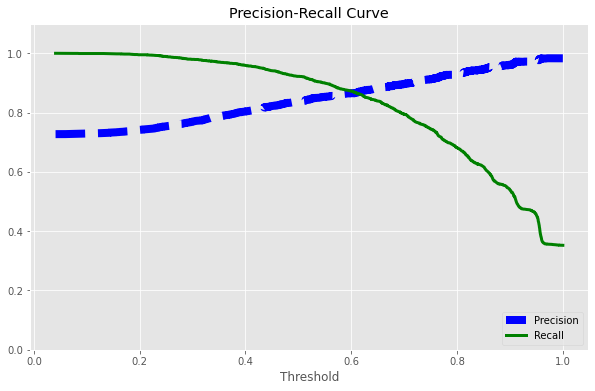

Optimal Threshold:  0.6093773734742217


In [77]:
plt.style.use('ggplot')

# Get the 2nd column of the matrix of predicted probabilities for each data point
#    The 2nd column stores the probalities of the positive class

# Method 1
y_scores = cross_val_predict(knnbest1, X_train1, y_train1, method="predict_proba", cv=5)[:, 1]


precisions, recalls, thresholds = precision_recall_curve(y_train1, y_scores)

print("Precisions: ", precisions)
print("\nRecalls: ", recalls)
print("\nThresholds: ", thresholds)


fig = plt.figure(figsize=(10, 6))
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--",  linewidth=8, label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-",  linewidth=3, label="Recall") 
    plt.xlabel("Threshold")
    plt.legend(loc="lower right")
    plt.title('Precision-Recall Curve')
    #plt.xlim([0, 1])
    plt.ylim([0, 1.1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


threshold_optimal = -1
for i in range(len(precisions)):
    if(precisions[i] == recalls[i]):
        threshold_optimal = thresholds[i]

print("Optimal Threshold: ", threshold_optimal)

### Step 16.
Evaluate your model on the test data and report the performance measures.
1. Precision
2. Recall
3. F1 score
4. Confusion matrix
5. Accuracy

In [79]:
print("Test: Performance Measures Based on the Default Threshold:\n")


y_test_pred = knnbest1.predict(X_test1)

test_accuracy_knn = np.mean(y_test1 == y_test_pred)

print("Test Accuracy (Default Threshold 0.5): ", test_accuracy_knn)

# Precision, Recall, F1 Score and Confusion Matrix for the Default Threshold 0.5
precision_test = precision_score(y_test1, y_test_pred) 
print("\nTest Precision (Default Threshold 0.5) = %f" % precision_test)

recall_test = recall_score(y_test1, y_test_pred)
print("Test Recall (Default Threshold 0.5) = %f" % recall_test)


f1_test = f1_score(y_test1, y_test_pred)
print("Test F1 Score (Default Threshold 0.5) = %f" % f1_test)

print("Test Confusion Matrix (Default Threshold 0.5)\n", confusion_matrix(y_test1, y_test_pred))

Test: Performance Measures Based on the Default Threshold:

Test Accuracy (Default Threshold 0.5):  0.7836734693877551

Test Precision (Default Threshold 0.5) = 0.788811
Test Recall (Default Threshold 0.5) = 0.902400
Test F1 Score (Default Threshold 0.5) = 0.841791
Test Confusion Matrix (Default Threshold 0.5)
 [[204 151]
 [ 61 564]]
